# 🧪 GNN Test

Dieses Notebook ist ein erster Test des GNN Ansatzes für die Vorhersage von $\mu$ und $\sigma$

#### 🌩️ Google Colab Code

In [ ]:
#! Only Run for Colab usage
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/GNNPP
!git pull https://github.com/m-j-w-f/GNNPP
!git checkout testing

import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

import sys
sys.path.append('../utils')
from utils.helpers import load_data, load_stations

Mounted at /content/drive
/content/drive/MyDrive/GNNPP
From https://github.com/m-j-w-f/GNNPP
 * branch            HEAD       -> FETCH_HEAD
Already up to date.
Already on 'testing'
Your branch is up to date with 'origin/testing'.
2.0.0+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 69.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 42.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## ✨ Imports

In [2]:
# Used to import the helper functions
import sys
sys.path.append('../utils')
from helpers import load_data, load_stations

In [3]:
data = load_data(indexed=False)
data.drop(['sm_mean', 'sm_var'], inplace=True, axis=1) # drop incomplete rows for fist test

## 💽 Create the torch dataset

The Dataset which is a `pandas.DataFrame` gets converted to a `torch_geometric.data` object, which then can be processed by the GNN


In [4]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import geopy.distance
import pandas as pd
import numpy as np
from tqdm import tqdm

In [5]:
def dist_km(lat1, lon1, lat2, lon2):
    """Returns distance bewtween two stations in km using the the WGS-84 ellipsoid.

    Args:
        lat1 (float): latitude of first station
        lat2 (float): latitude of second station
        lon1 (float): longitude of first station
        lon2 (float): longitude of second station

    Returns:
        float: distance in km
    """
    return geopy.distance.geodesic((lat1, lon1), (lat2, lon2)).km


def compute_dist_matrix(df: pd.DataFrame) -> np.ndarray:
    """Returns a distance matrix between stations.

    Args:
        df (pd.DataFrame): dataframe with stations

    Returns:
        np.ndarray: distance matrix
    """
    coords_df = df[['lat', 'lon']].copy()

    # create numpy arrays for latitudes and longitudes
    latitudes = np.array(coords_df['lat'])
    longitudes = np.array(coords_df['lon'])

    # create a meshgrid of latitudes and longitudes
    lat_mesh, lon_mesh = np.meshgrid(latitudes, longitudes)

    # calculate distance matrix using vectorized distance function
    distance_matrix = np.vectorize(dist_km)(lat_mesh, lon_mesh, lat_mesh.T, lon_mesh.T)
    return distance_matrix


def create_data(data: pd.DataFrame, date: pd.Timestamp, mask: np.ndarray) -> Data:
    """
    Create a PyTorch Geometric Data object from a given date.

    Args:
        data (pd.DataFrame): dataframe with stations and observations
        date (pd.Timestamp): date to create data for
        mask (np.ndarray): Boolean array that represents the edges with distance less than max_dist

    Returns:
        Data: PyTorch Geometric Data object
    """
    # Get the rows of the dataframe corresponding to the current date
    df = data[data['date'] == date]

    # Get the stations that reported for the current date
    reporting_stations = df['station'].to_numpy()
    assert any(df.station.value_counts() != 1) == False # Any Station that reports data should appear only once
    assert all(reporting_stations[:-1] < reporting_stations[1:]) # Array of Stations should be in ascending order

    # Create feature tensor (stations are orderd in the data)
    node_features = df.drop(['date', 'obs'], axis=1).to_numpy()
    x = torch.tensor(node_features, dtype=torch.float)
    
    # Create target tensor
    target = df['obs'].to_numpy()
    y = torch.tensor(target, dtype=torch.float)

    # Create a pairwise distance matrix (omit non reporting stations)
    mesh = np.ix_(reporting_stations, reporting_stations)
    mask_sliced = mask[mesh]

    # Get the indices of the edges to include
    edges = np.argwhere(mask_sliced)
    edges = edges.T

    edge_index = torch.tensor(edges, dtype=torch.int)
    assert edge_index.shape[0] == 2
    
    # Create a PyTorch Geometric Data object
    data = Data(x=x, y=y, edge_index=edge_index)
    return data


In [6]:
stations = load_stations(data)
dist_matrix = compute_dist_matrix(stations)

# TODO set the maximum distance (might want to get this from a configuration file)
max_dist = 50

# Create a boolean mask indicating which edges to include
mask = (dist_matrix <= max_dist) & (dist_matrix != 0)

In [7]:
torch_data = []

for date in tqdm(data['date'].unique()):
    torch_data.append(create_data(data=data, date=date, mask=mask))

100%|██████████| 3651/3651 [00:16<00:00, 221.81it/s]


#### 💿 Dataloaders

In [8]:
# Definition of train_loader and valid_loader
# TODO another hyperparameter here 
train_loader = DataLoader(torch_data[:3000], batch_size=16, shuffle=True)
valid_loader = DataLoader(torch_data[3000:], batch_size=16, shuffle=True)

### 👀 Visualizations of Graph to test if everything worked fine

In [9]:
import networkx as nx
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
%matplotlib inline
plt.style.use('default')

In [10]:
def visualize_graph(d: Data):
    G = to_networkx(d, to_undirected=True)
    pos =  d.x[:,-4:-2].detach().numpy() # TODO this does not work if new features are added (add dict featureToIndex)
    pos = np.transpose([pos[:, 1], pos[:, 0]]) # Switch latitude and longitude
    dict_pos = {i: p.tolist() for i, p in enumerate(pos)}
    
    proj = ccrs.PlateCarree()
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(1, 1, 1, projection=proj)
    ax.coastlines()
    ax.set_extent([5, 16, 47, 56], crs=proj)
    ax.add_feature(cfeature.LAND, color="lightgrey")
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.OCEAN)
    
    nx.draw_networkx(G, pos=dict_pos, node_size=5, ax=ax, with_labels=False)
    
    # Fix the aspect ratio of the map
    lat_center = (ax.get_extent()[2] + ax.get_extent()[3]) / 2
    ax.set_aspect(1 / np.cos(np.radians(lat_center)))
    
    ax.set_title("Active weather stations in Germany")
    
    plt.show()

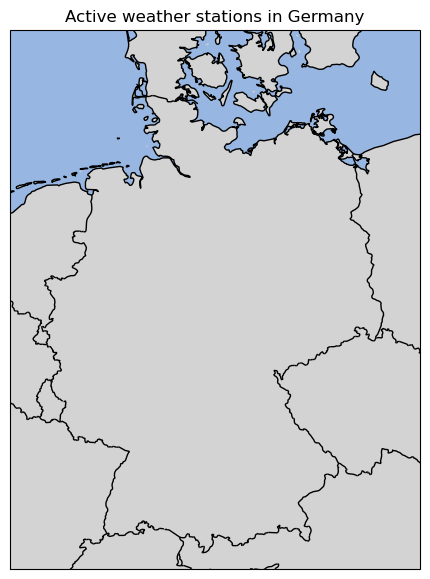

In [11]:
visualize_graph(torch_data[100])

## 🕸️ GNN construction
After generating the data, the GNN is defined

### 🚧 TODOS
 - Define Custom Loss Function
 - Try different architectures
 - Train Network
 - W&B maybe

### 📉 CRPS Loss Function

\begin{align*}

    \operatorname{crps}(F,X)=&\int_{-\inf}^{\inf}\left(F(y)-\boldsymbol{1}_{(y-x)}\right)^2dy\\

\end{align*}

Closed form expression from Gneiting et al. (2005)

\begin{align*}

    \operatorname{crps}\left(\mathcal{N}\left(\mu, \sigma^2\right), y\right)= & \sigma\left\{\frac{y-\mu}{\sigma}\left[2 \Phi\left(\frac{y-\mu}{\sigma}\right)-1\right] +2 \varphi\left(\frac{y-\mu}{\sigma}\right)-\frac{1}{\sqrt{\pi}}\right\}

\end{align*}

$\Phi\left(\frac{y-\mu}{\sigma}\right)$ denotes the CDF of a standard normal distribution and $\varphi\left(\frac{y-\mu}{\sigma}\right)$ denotes the PDF of a standard normal distribution


In [12]:
def crps(mu: torch.tensor, sigma: torch.tensor, y: torch.tensor):
    """Calculates the Continuous Ranked Probability Score (CRPS) assuming normally distributed data

    Args:
        mu (torch.tensor): mean
        sigma (torch.tensor): standard deviation
        y (torch.tensor): observed data

    Returns:
        torch.tensor: CRPS value
    """
    sigma = torch.abs(sigma) # make sure sigma is always positive
    PI = 3.14159265359
    omega = (y - mu) / sigma
    # PDF of normal distribution at omega
    pdf = 1/(torch.sqrt(torch.tensor(2 * PI))) * torch.exp(-0.5 * omega ** 2)
    
    # Source: https://stats.stackexchange.com/questions/187828/how-are-the-error-function-and-standard-normal-distribution-function-related
    cdf = 0.5 * (1 + torch.erf(omega / torch.sqrt(torch.tensor(2))))
    
    crps = sigma * (omega * (2 * cdf - 1) + 2 * pdf - 1/torch.sqrt(torch.tensor(PI)))
    return  torch.mean(crps)

### 🌐 GNN 

In the following section the gnn is constructed. This is largely based on the [PyG Colab Notebooks](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8?usp=sharing).

#### 🚧 TODO
 - impement early stopping

In [13]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [15]:
class GNN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, heads):
        super(GNN, self).__init__()
        self.conv1 = GATConv(num_features, hidden_channels, heads=8)
        self.conv2 = GATConv(-1, hidden_channels, heads=8)
        self.fc1 = Linear(hidden_channels*8, 64)
        self.fc2 = Linear(64, 2)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        mu, sigma = torch.split(x, 1, dim=-1)
        return mu, sigma

In [16]:
# Initialize the model and optimizer
num_features = torch_data[0].num_features
model = GNN(num_features=num_features, hidden_channels=16, heads=8)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [20]:

#TODO more hyperparams here

n_epochs = 100
patience = 10
best_val_loss = float('inf')
no_improvement = 0

def train(data):
    data.to(device)
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    mu, sigma = out
    loss = crps(mu, sigma, data.y)
    loss.backward()
    optimizer.step()
    return loss

train_losses = []
validation_losses = []


for epoch in range(n_epochs):
    # Train for one epoch
    model.train()
    train_loss = 0.0
    for data in train_loader:
        loss = train(data)
        train_loss += loss.item() * data.num_graphs
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
        
    # Evaluate on the validation set
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in valid_loader:
            data.to(device)
            out = model(data.x, data.edge_index)
            mu, sigma = out
            loss = crps(mu, sigma, data.y)
            val_loss += loss.item() * data.num_graphs
        val_loss /= len(valid_loader.dataset)
        validation_losses.append(val_loss)

    # Print the training and validation loss for each epoch
    print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Check if the validation loss has improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement = 0
    else:
        no_improvement += 1
    # Early stopping
    if no_improvement == patience:
        print('Early stopping.')
        break

NotImplementedError: The operator 'aten::scatter_reduce.two_out' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

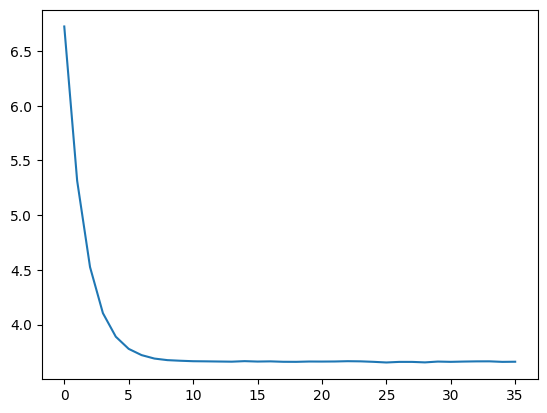

In [ ]:
plt.plot(validation_losses)

In [ ]:
# Save Model and losses
torch.save(model.state_dict(), "modelsAndVariables/model.pt")
train_losses = np.array(train_losses)
np.save("modelsAndVariables/train_losses.npy", train_losses)
validation_losses = np.array(validation_losses)
np.save("modelsAndVariables/test_losses.npy", test_losses)

In [ ]:
# Test evaluations

model.eval()

test = torch_data[3200]
test.to(device)

mu, sigma = model(data.x, data.edge_index)
print(sigma)

tensor([[6.9008],
        [6.9008],
        [6.9008],
        ...,
        [6.9008],
        [6.9008],
        [6.9008]], device='cuda:0', grad_fn=<SplitBackward0>)
